In [ ]:
# Cài thư viện cần thiết
!pip install python-binance pandas mplfinance

In [ ]:
#Khai báo thư viện
import pandas as pd
import numpy as np #Xử lý dữ liệu
#import mplfinance as mpf #Trực quan, vẽ biểu đồ dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta, timezone
from decimal import Decimal, ROUND_DOWN #Xử lý số thập phân
#import mysql.connector
import time
from google.colab import userdata #Lấy Serect key của colab
from google.colab import drive

#XÂY DỰNG MÔ HÌNH LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential #Đầu vào
from tensorflow.keras.layers import LSTM #Học phụ thuộc
from tensorflow.keras.layers import Dense, Dropout #Tránh overfitting và đầu ra


from sklearn.preprocessing import MinMaxScaler #Chuẩn hóa dữ liệu
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score #Đánh giá hiệu suất

#**Thu thập dữ liệu**

In [ ]:
#Lấy dữ liệu
from binance.client import Client

# Mount Google Drive
drive.mount('/content/drive')

# Kết nối Binance
api_key = userdata.get('APIKeyBinnace')
secret_key = userdata.get('SecretKeyBinnace')
client = Client(api_key, secret_key)

# Tham số
symbol = "BTCUSDT"
interval = Client.KLINE_INTERVAL_15MINUTE
start_date = "1 Jan 2017"

# Lấy dữ liệu
klines = client.get_historical_klines(symbol, interval, start_date)

# Xuất ra CSV vào Drive
csv_path = "/content/drive/MyDrive/BTCUSDT_15m_raw.csv"
pd.DataFrame(klines).to_csv(csv_path, index=False, header=False)

# In ra thử 1 cây nến đầu tiên
print(klines[0])
print(f"File đã lưu tại: {csv_path}")

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Đường dẫn file CSV raw trong Drive
csv_path = "/content/drive/MyDrive/BTCUSDT_15m_raw.csv"

# Đọc file CSV
df = pd.read_csv(csv_path, header=None)

# Kiểm tra kiểu dữ liệu hiện tại của từng cột
print(f"Số dòng: {df.shape[0]}, số cột: {df.shape[1]}")
print(df.dtypes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Số dòng: 280253, số cột: 12
0       int64
1     float64
2     float64
3     float64
4     float64
5     float64
6       int64
7     float64
8       int64
9     float64
10    float64
11      int64
dtype: object


#**Xử lý và trực quan hóa dữ liệu**

##**Khám phá dữ liệu ban đầu**

In [ ]:
print(df.head()) #5 dòng đầu

              0        1        2        3        4          5   \
0  1502942400000  4261.48  4280.56  4261.48  4261.48   2.189061   
1  1502943300000  4261.48  4270.41  4261.32  4261.45   9.119865   
2  1502944200000  4280.00  4310.07  4267.99  4310.07  21.923552   
3  1502945100000  4310.07  4313.62  4291.37  4308.83  13.948531   
4  1502946000000  4308.83  4328.69  4304.31  4304.31   5.101153   

              6             7   8          9             10  11  
0  1502943299999   9333.620962   9   0.489061   2089.104962   0  
1  1502944199999  38891.133046  40   3.447113  14703.934995   0  
2  1502945099999  94080.917568  58  20.421317  87620.977876   0  
3  1502945999999  60060.466816  64  10.803012  46538.460109   0  
4  1502946899999  22006.533111  44   3.496635  15093.783057   0  


In [ ]:
print(df.tail()) #5 dòng cuối

                   0          1          2          3          4          5   \
280248  1755674100000  113722.84  113837.93  113720.86  113720.87   91.20673   
280249  1755675000000  113720.87  113720.87  113588.00  113612.01  127.34973   
280250  1755675900000  113612.01  113672.74  113432.00  113490.13  124.31949   
280251  1755676800000  113490.14  113609.94  113401.00  113609.94  119.43721   
280252  1755677700000  113609.94  113854.34  113609.93  113854.33  186.23173   

                   6             7      8         9             10  11  
280248  1755674999999  1.037709e+07  16790  56.19940  6.394022e+06   0  
280249  1755675899999  1.447374e+07  21108  65.78950  7.476427e+06   0  
280250  1755676799999  1.411649e+07  17054  62.15294  7.058497e+06   0  
280251  1755677699999  1.355756e+07  25094  73.33694  8.325082e+06   0  
280252  1755678599999  2.118173e+07  21800  94.40609  1.073844e+07   0  


In [ ]:
print(df.info()) #Thông tin tổng quan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280253 entries, 0 to 280252
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       280253 non-null  int64  
 1   1       280253 non-null  float64
 2   2       280253 non-null  float64
 3   3       280253 non-null  float64
 4   4       280253 non-null  float64
 5   5       280253 non-null  float64
 6   6       280253 non-null  int64  
 7   7       280253 non-null  float64
 8   8       280253 non-null  int64  
 9   9       280253 non-null  float64
 10  10      280253 non-null  float64
 11  11      280253 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 25.7 MB
None


In [ ]:
print(df.describe()) #Kiểm tra thống kê cơ bản

                 0              1              2              3   \
count  2.802530e+05  280253.000000  280253.000000  280253.000000   
mean   1.629462e+12   32839.944117   32908.548056   32769.098271   
std    7.293337e+10   29149.178672   29195.083913   29102.217734   
min    1.502942e+12    2830.000000    2880.010000    2817.000000   
25%    1.566355e+12    8911.070000    8935.000000    8884.000000   
50%    1.629553e+12   23359.320000   23403.940000   23312.570000   
75%    1.692621e+12   48265.890000   48397.030000   48132.050000   
max    1.755678e+12  124243.310000  124474.000000  123666.010000   

                  4              5             6             7   \
count  280253.000000  280253.000000  2.802530e+05  2.802530e+05   
mean    32840.323336     673.062480  1.629463e+12  1.833338e+07   
std     29149.538499    1084.658613  7.293337e+10  2.865500e+07   
min      2820.000000       0.000000  1.502943e+12  0.000000e+00   
25%      8911.010000     183.691948  1.566355e+12  2

## **Tiền xử lý dữ liệu**


In [ ]:
#Thêm tiêu đề cho các cột
# Gán tên cột theo thứ tự Binance cung cấp
df.columns = ['open_time','Open','High','Low','Close','Volume','close_time',
              'quote_asset_volume','number_of_trades','taker_buy_base_asset_volume',
              'taker_buy_quote_asset_volume','ignore']
df.columns

Index(['open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore'],
      dtype='object')

In [ ]:
#Loại bỏ cột không cần thiết
df = df[['open_time','Open','High','Low','Close','Volume']]
df

,open_time,Open,High,Low,Close,Volume
0,1502942400000,4261.48,4280.56,4261.48,4261.48,2.189061
1,1502943300000,4261.48,4270.41,4261.32,4261.45,9.119865
2,1502944200000,4280.00,4310.07,4267.99,4310.07,21.923552
3,1502945100000,4310.07,4313.62,4291.37,4308.83,13.948531
4,1502946000000,4308.83,4328.69,4304.31,4304.31,5.101153
...,...,...,...,...,...,...
280248,1755674100000,113722.84,113837.93,113720.86,113720.87,91.206730
280249,1755675000000,113720.87,113720.87,113588.00,113612.01,127.349730
280250,1755675900000,113612.01,113672.74,113432.00,113490.13,124.319490
280251,1755676800000,113490.14,113609.94,113401.00,113609.94,119.437210


In [ ]:
print(df.isna().sum()) #Kiểm tra giá trị trống
print(df.duplicated().sum()) #Kiểm tra trùng nhau

open_time    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64
0


In [ ]:
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms') #Chuyển kiểu open_time sang datetime
df.set_index('open_time', inplace=True) # Set open_time làm index

In [ ]:
df

,Open,High,Low,Close,Volume
open_time,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45,9.119865
2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07,21.923552
2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83,13.948531
2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31,5.101153
...,...,...,...,...,...
2025-08-20 07:15:00,113722.84,113837.93,113720.86,113720.87,91.206730
2025-08-20 07:30:00,113720.87,113720.87,113588.00,113612.01,127.349730
2025-08-20 07:45:00,113612.01,113672.74,113432.00,113490.13,124.319490


In [ ]:
# Kiểm tra outlier bằng IQR
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Close'] < lower_bound) | (df['Close'] > upper_bound)]['Close']
print(f"Số lượng outlier (dựa trên IQR): {len(outliers)}")
print(f"Outlier min: {outliers.min()}, max: {outliers.max()}")

Số lượng outlier (dựa trên IQR): 6163
Outlier min: 107298.42, max: 124243.32


In [ ]:
# Kiểm tra phân bố outlier theo năm
df['Year'] = df.index.year
outliers = df[(df['Close'] >= 107298.42) & (df['Close'] <= 124243.32)]
print(outliers.groupby('Year').size())

Year
2024      17
2025    6146
dtype: int64


In [ ]:
# Tính MA20
df['MA20'] = df['Close'].rolling(window=20).mean()

# Tính RSI14
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain = pd.Series(gain, index=data.index)
    loss = pd.Series(loss, index=data.index)
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan)  # Xử lý chia cho 0
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = calculate_rsi(df['Close'], periods=14)

# Xử lý giá trị thiếu do tính toán
df = df.dropna()
print(f"Dữ liệu sau bổ sung MA20, RSI14: {df.shape}")

Dữ liệu sau bổ sung MA20, RSI14: (280233, 8)


In [ ]:
#Kiểm tra lại dữ liệu
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280233 entries, 2017-08-17 08:45:00 to 2025-08-20 08:15:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Open    280233 non-null  float64
 1   High    280233 non-null  float64
 2   Low     280233 non-null  float64
 3   Close   280233 non-null  float64
 4   Volume  280233 non-null  float64
 5   Year    280233 non-null  int32  
 6   MA20    280233 non-null  float64
 7   RSI14   280233 non-null  float64
dtypes: float64(7), int32(1)
memory usage: 18.2 MB
None


In [ ]:
print(df.describe())

                Open           High            Low          Close  \
count  280233.000000  280233.000000  280233.000000  280233.000000   
mean    32841.855988   32910.463483   32771.005906   32842.234816   
std     29149.269830   29195.174494   29102.310023   29149.630034   
min      2830.000000    2880.010000    2817.000000    2820.000000   
25%      8912.100000    8936.880000    8885.000000    8912.430000   
50%     23362.780000   23405.000000   23314.900000   23362.970000   
75%     48267.590000   48399.000000   48133.330000   48267.950000   
max    124243.310000  124474.000000  123666.010000  124243.320000   

              Volume           Year           MA20          RSI14  
count  280233.000000  280233.000000  280233.000000  280233.000000  
mean      673.105907    2021.134849   32838.532085      50.612246  
std      1084.682869       2.343292   29145.361384      15.221196  
min         0.000000    2017.000000    2995.682000       0.020264  
25%       183.717630    2019.000000   

In [ ]:
#Xuất file CSV dữ liệu dã xử lý
# Đường dẫn lưu file xử lý xong
output_path = "/content/drive/MyDrive/BTCUSDT_15m_processed.csv"

# Xuất DataFrame ra CSV
df.to_csv(output_path, index=True)

print(f"Đã lưu file xử lý xong tại: {output_path}")

Đã lưu file xử lý xong tại: /content/drive/MyDrive/BTCUSDT_15m_processed.csv


## **Phân tích dữ liệu qua các năm**

###**2017**

In [ ]:
btc_2017 = df[df.index.year == 2017]
print("Số lượng bản ghi 2017:", len(btc_2017))
print(btc_2017['Close'].describe())

Số lượng bản ghi 2017: 13084
count    13084.000000
mean      7576.355624
std       4262.715313
min       2820.000000
25%       4308.105000
50%       5781.010000
75%       9510.005000
max      19756.020000
Name: Close, dtype: float64


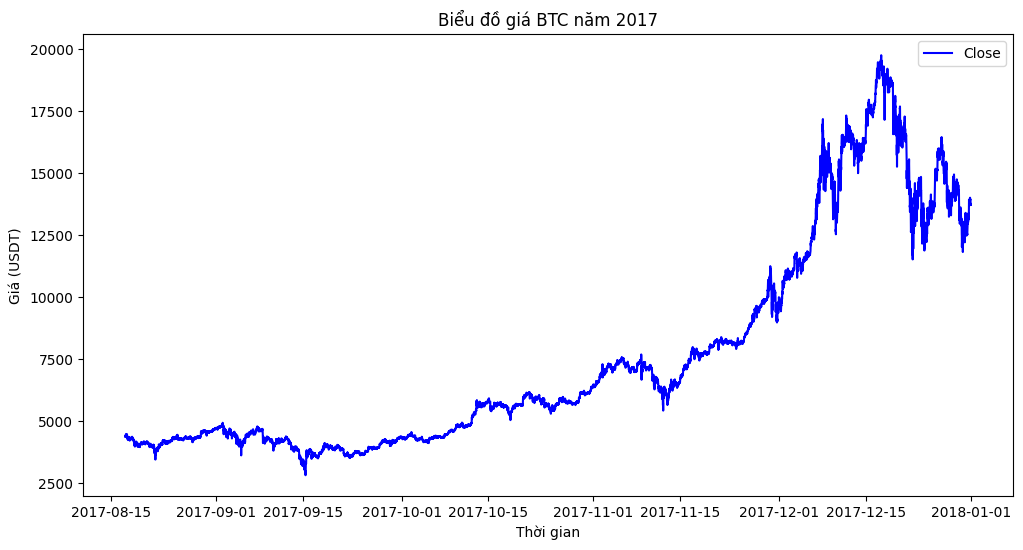

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2017.index, btc_2017['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2017')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()


###**2018**

In [ ]:
#Lọc dữ liệu năm 2018
btc_2018 = df.loc['2018-01-01':'2018-12-31']
print("Số lượng bản ghi 2018:", len(btc_2018))
print(btc_2018['Close'].describe())

Số lượng bản ghi 2018: 34778
count    34778.000000
mean      7539.923261
std       2387.267314
min       3167.070000
25%       6408.027500
50%       6907.160000
75%       8593.702500
max      17173.970000
Name: Close, dtype: float64


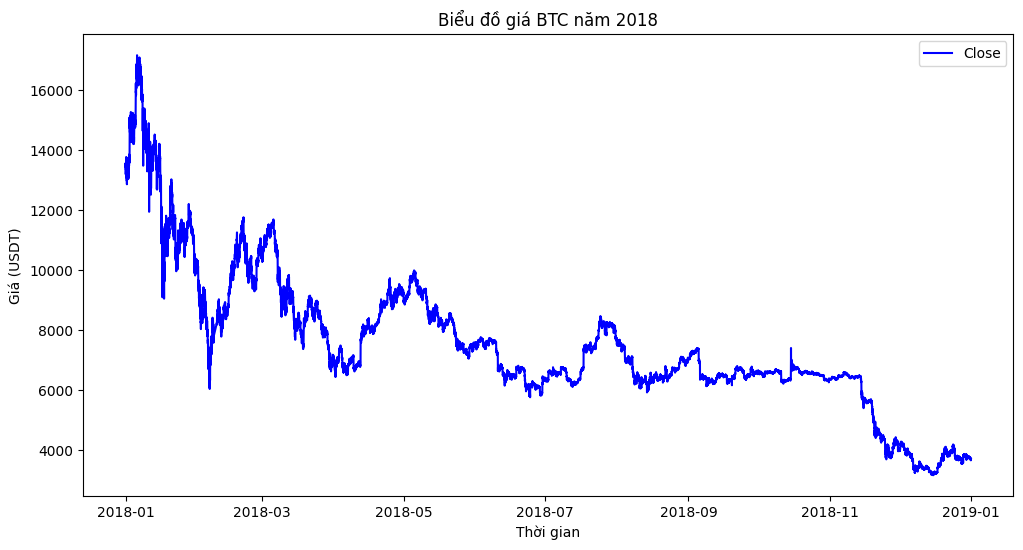

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2018.index, btc_2018['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2018')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

###**2019**

In [ ]:
#Lọc dữ liệu năm 2019
btc_2019 = df.loc['2019-01-01':'2019-12-31']
print("Số lượng bản ghi 2019:", len(btc_2019))
print(btc_2019['Close'].describe())

Số lượng bản ghi 2019: 34923
count    34923.000000
mean      7353.050820
std       2643.552613
min       3366.410000
25%       4445.730000
50%       7800.870000
75%       9566.135000
max      13960.760000
Name: Close, dtype: float64


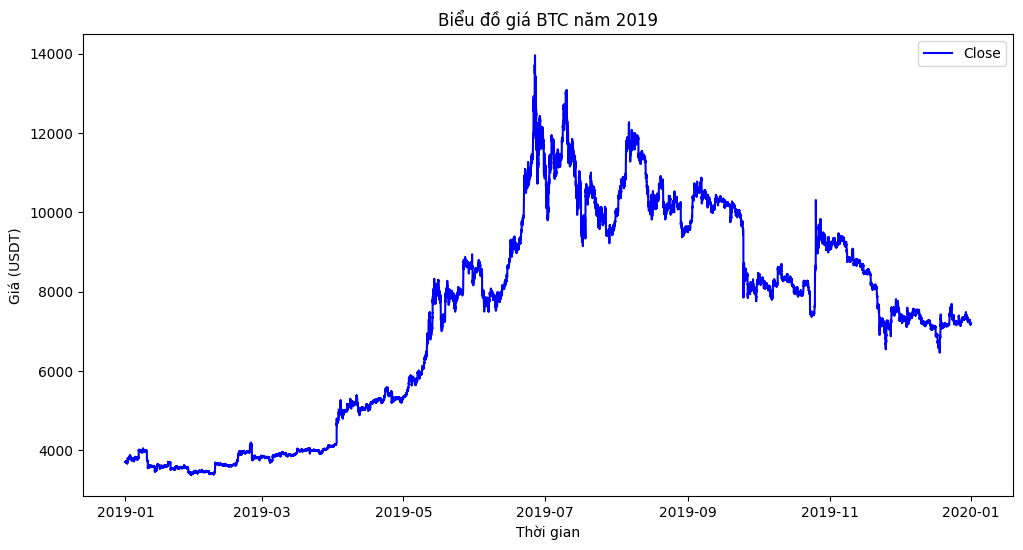

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2019.index, btc_2019['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2019')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

###**2020**

In [ ]:
#Lọc dữ liệu năm 2020
btc_2020 = df.loc['2020-01-01':'2020-12-31']
print("Số lượng bản ghi 2020:", len(btc_2020))
print(btc_2020['Close'].describe())

Số lượng bản ghi 2020: 35053
count    35053.000000
mean     11066.416934
std       4240.579281
min       3882.220000
25%       8855.900000
50%       9692.040000
75%      11627.400000
max      29248.310000
Name: Close, dtype: float64


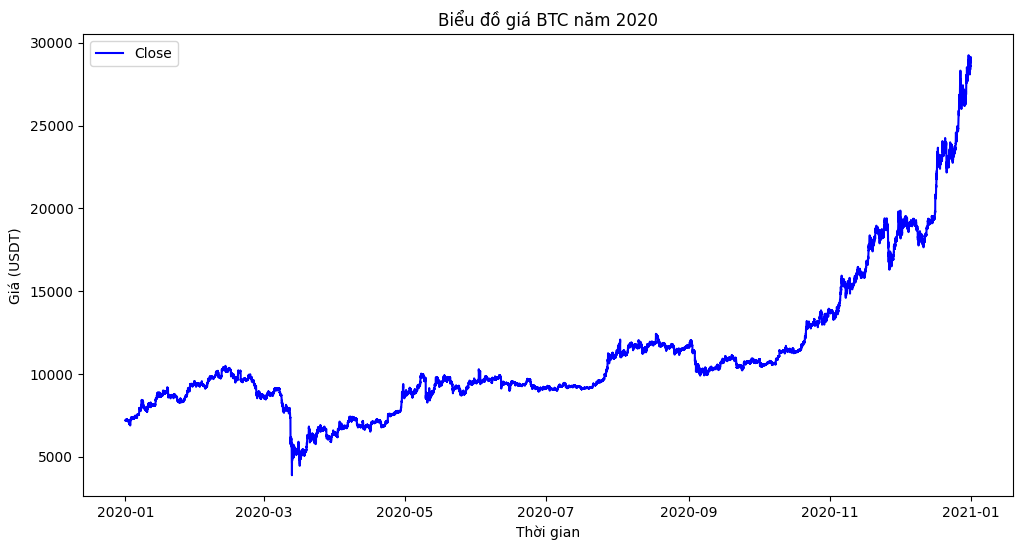

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2020.index, btc_2020['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2020')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

###**2021**

In [ ]:
#Lọc dữ liệu năm 2021
btc_2021 = df.loc['2021-01-01':'2021-12-31']
print("Số lượng bản ghi 2021:", len(btc_2021))
print(btc_2021['Close'].describe())

Số lượng bản ghi 2021: 34974
count    34974.000000
mean     47357.895166
std       9821.815415
min      28752.800000
25%      38060.395000
50%      47898.270000
75%      56203.777500
max      68718.900000
Name: Close, dtype: float64


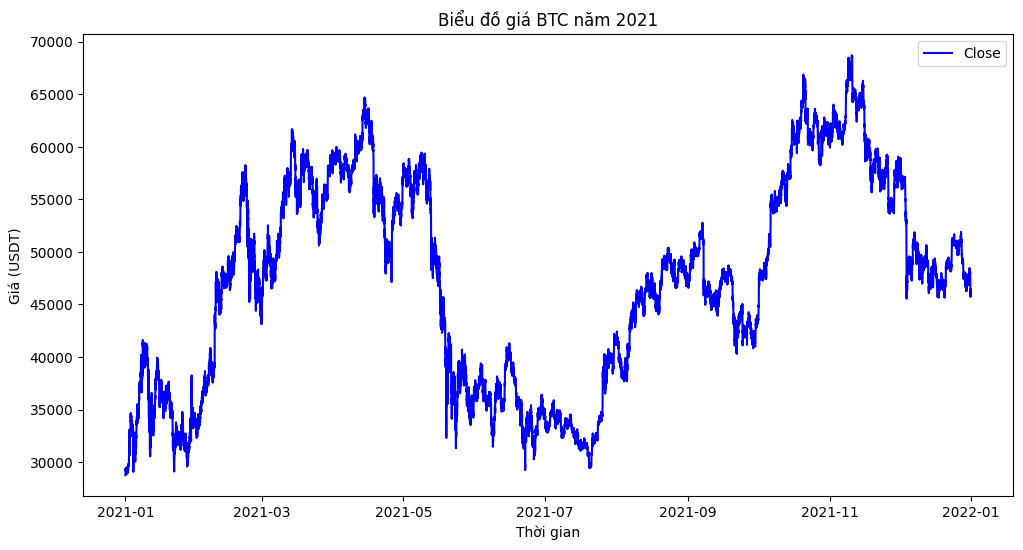

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2021.index, btc_2021['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2021')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

###**2022**

In [ ]:
#Lọc dữ liệu năm 2022
btc_2022 = df.loc['2022-01-01':'2022-12-31']
print("Số lượng bản ghi 2022:", len(btc_2022))
print(btc_2022['Close'].describe())

Số lượng bản ghi 2022: 35040
count    35040.000000
mean     28226.341193
std      10191.525718
min      15649.520000
25%      19520.727500
50%      23149.875000
75%      39014.985000
max      48118.480000
Name: Close, dtype: float64


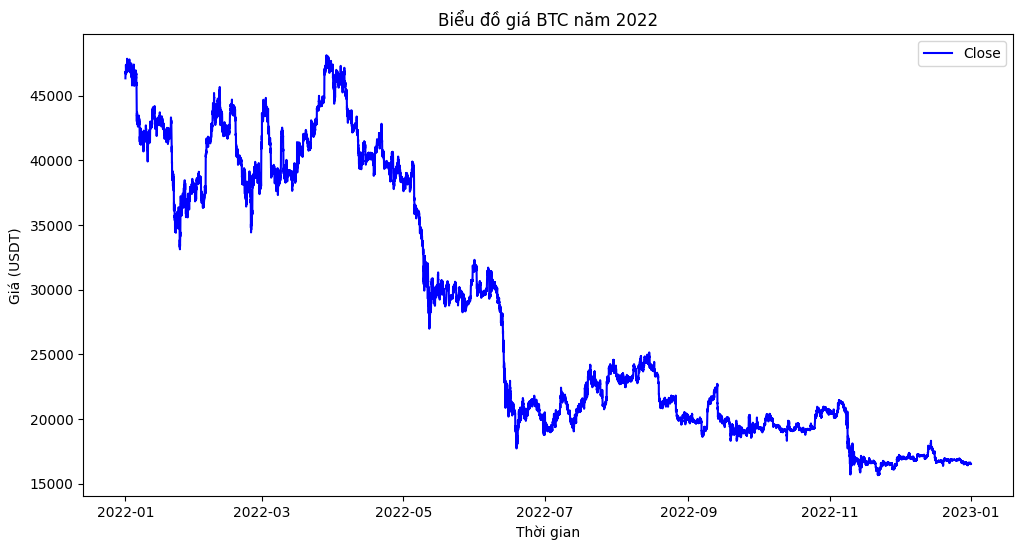

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2022.index, btc_2022['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2022')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

###**2023**

In [ ]:
#Lọc dữ liệu năm 2023
btc_2023 = df.loc['2023-01-01':'2023-12-31']
print("Số lượng bản ghi 2023:", len(btc_2023))
print(btc_2023['Close'].describe())

Số lượng bản ghi 2023: 35035
count    35035.00000
mean     28804.37489
std       5882.40774
min      16510.68000
25%      25922.28000
50%      27716.32000
75%      30286.63000
max      44563.95000
Name: Close, dtype: float64


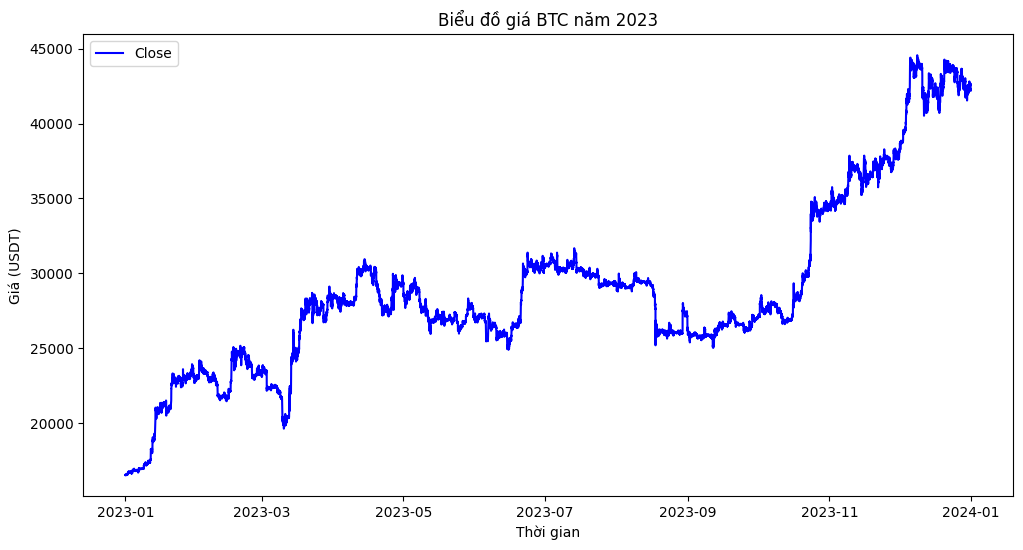

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2023.index, btc_2023['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2023')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

###**2024**

In [ ]:
#Lọc dữ liệu năm 2024
btc_2024 = df.loc['2024-01-01':'2024-12-31']
print("Số lượng bản ghi 2024:", len(btc_2024))
print(btc_2024['Close'].describe())

Số lượng bản ghi 2024: 35136
count     35136.000000
mean      65897.872800
std       14680.590731
min       38705.290000
25%       59012.755000
50%       64207.685000
75%       69067.312500
max      108258.390000
Name: Close, dtype: float64


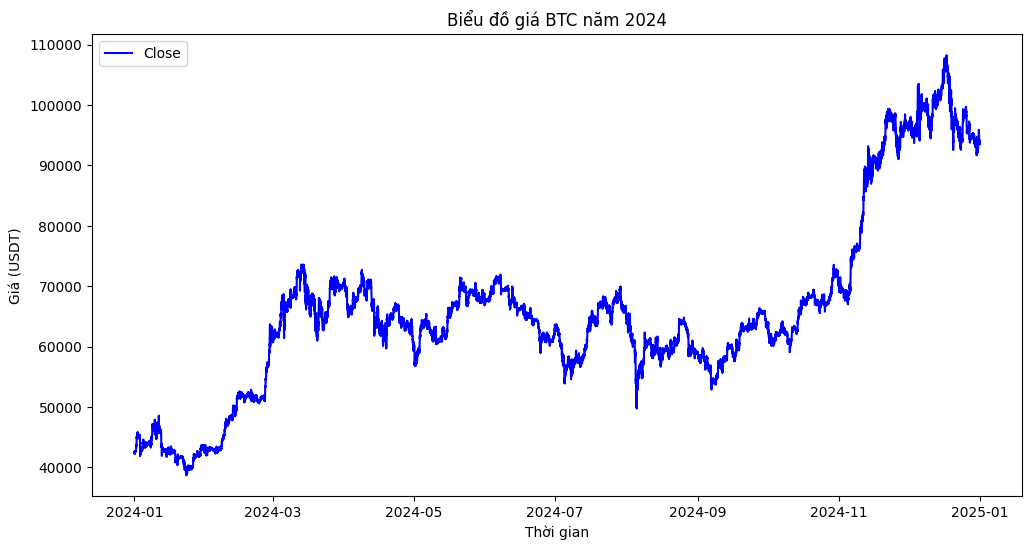

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2024.index, btc_2024['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2024')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

###**2025**

In [ ]:
#Lọc dữ liệu năm 2025
btc_2025 = df.loc['2025-01-01':'2025-12-31']
print("Số lượng bản ghi 2025:", len(btc_2025))
print(btc_2025['Close'].describe())

Số lượng bản ghi 2025: 22210
count     22210.000000
mean     100293.959503
std       11521.194940
min       74690.570000
25%       92870.172500
50%      101900.390000
75%      107956.010000
max      124243.320000
Name: Close, dtype: float64


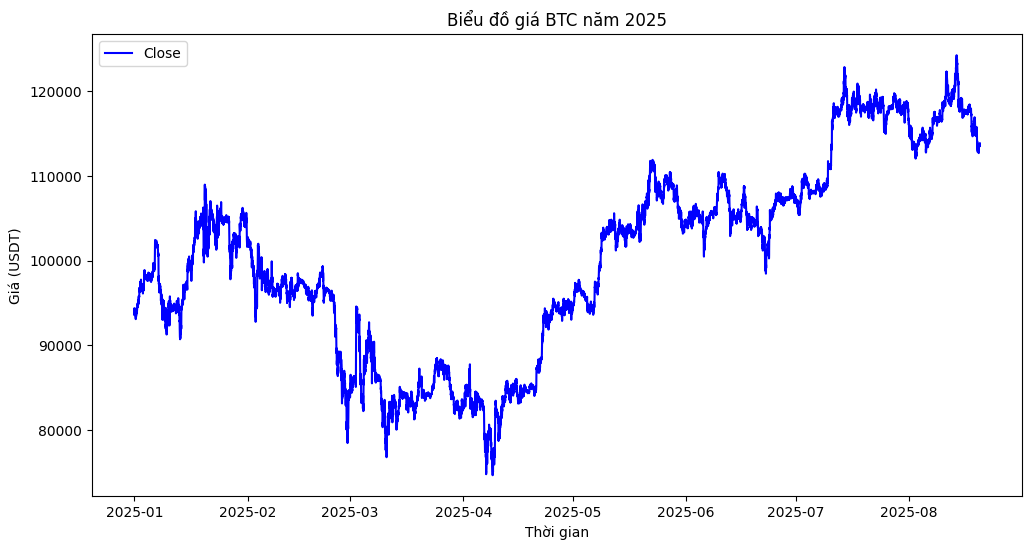

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(btc_2025.index, btc_2025['Close'], label='Close', color='blue')

plt.title('Biểu đồ giá BTC năm 2025')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.show()

##**Trực quan hóa dữ liệu**

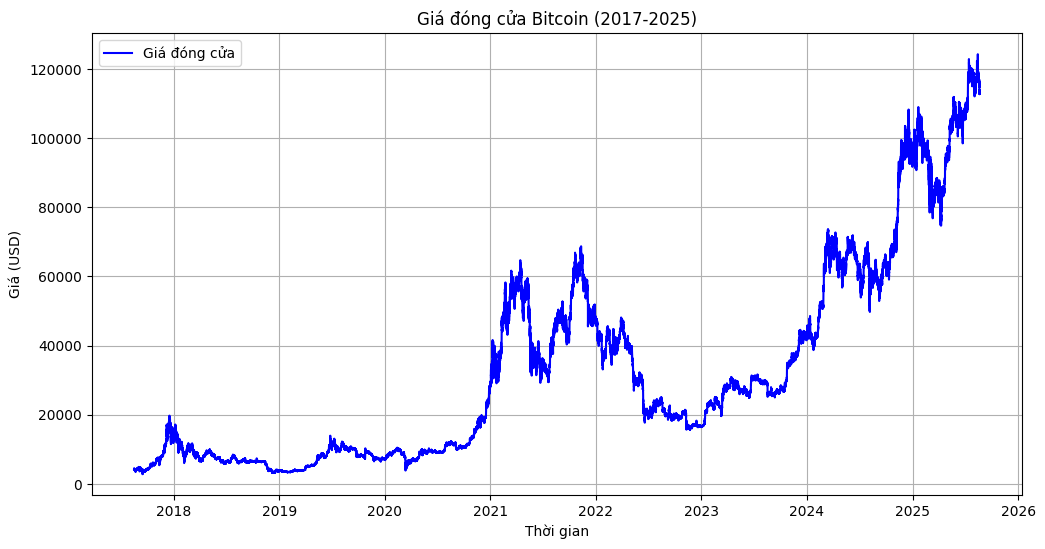

In [ ]:
#Biểu đồ giá đóng cửa
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Giá đóng cửa', color='blue')
plt.title('Giá đóng cửa Bitcoin (2017-2025)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True)
plt.show()

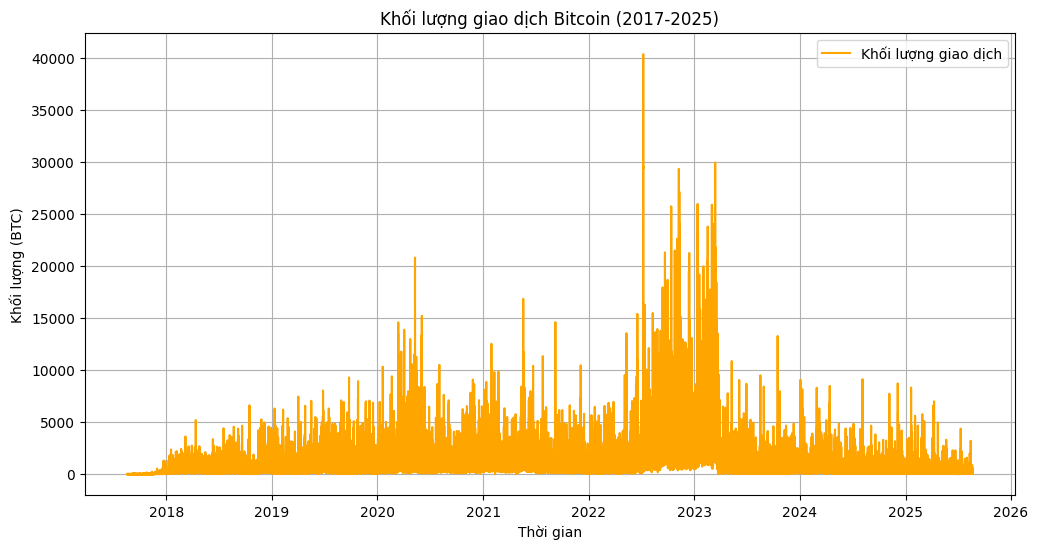

In [ ]:
#Biểu đồ khối lượng giao dịch
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volume'], label='Khối lượng giao dịch', color='orange')
plt.title('Khối lượng giao dịch Bitcoin (2017-2025)')
plt.xlabel('Thời gian')
plt.ylabel('Khối lượng (BTC)')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


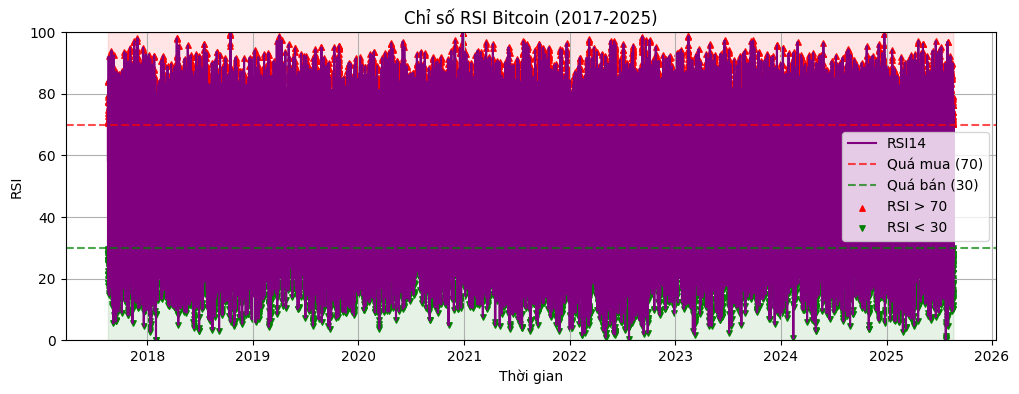

In [ ]:
plt.figure(figsize=(12, 4))

# Vẽ đường RSI14
plt.plot(df.index, df['RSI14'], label='RSI14', color='purple')

# Vẽ đường ngưỡng 70 (quá mua) và 30 (quá bán)
plt.axhline(70, linestyle='--', color='red', alpha=0.7, label='Quá mua (70)')
plt.axhline(30, linestyle='--', color='green', alpha=0.7, label='Quá bán (30)')

# Tô màu vùng quá mua (70-100) và quá bán (0-30)
plt.fill_between(df.index, 70, 100, color='red', alpha=0.1)
plt.fill_between(df.index, 0, 30, color='green', alpha=0.1)

# Highlight các điểm vượt ngưỡng
overbought = df[df['RSI14'] > 70]
oversold = df[df['RSI14'] < 30]
plt.scatter(overbought.index, overbought['RSI14'], color='red', marker='^', s=15, label='RSI > 70')
plt.scatter(oversold.index, oversold['RSI14'], color='green', marker='v', s=15, label='RSI < 30')

# Cài đặt biểu đồ
plt.title('Chỉ số RSI Bitcoin (2017-2025)')
plt.xlabel('Thời gian')
plt.ylabel('RSI')
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

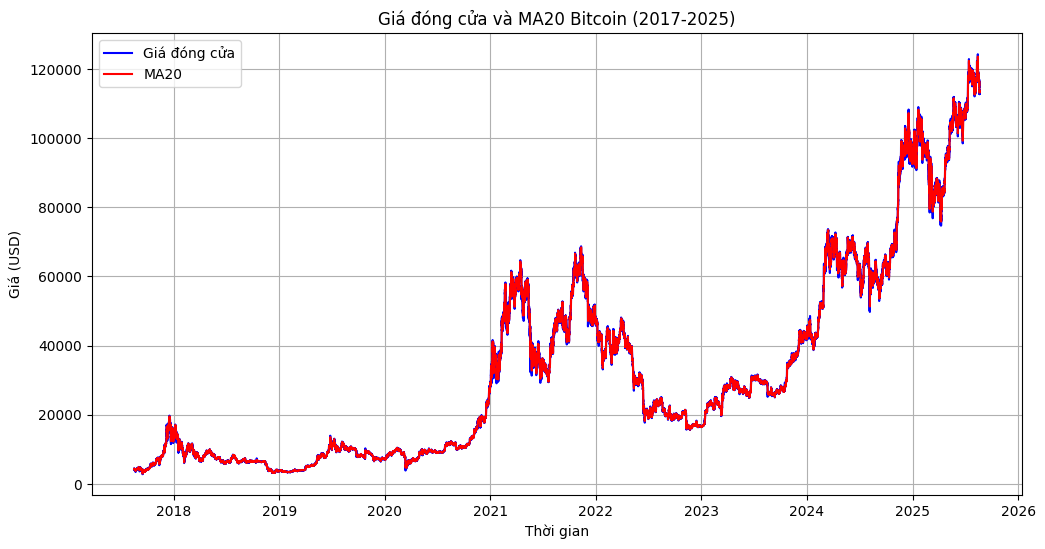

In [ ]:
#Biểu đồ đường MA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Giá đóng cửa', color='blue')
plt.plot(df.index, df['MA20'], label='MA20', color='red')
plt.title('Giá đóng cửa và MA20 Bitcoin (2017-2025)')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True)
plt.show()

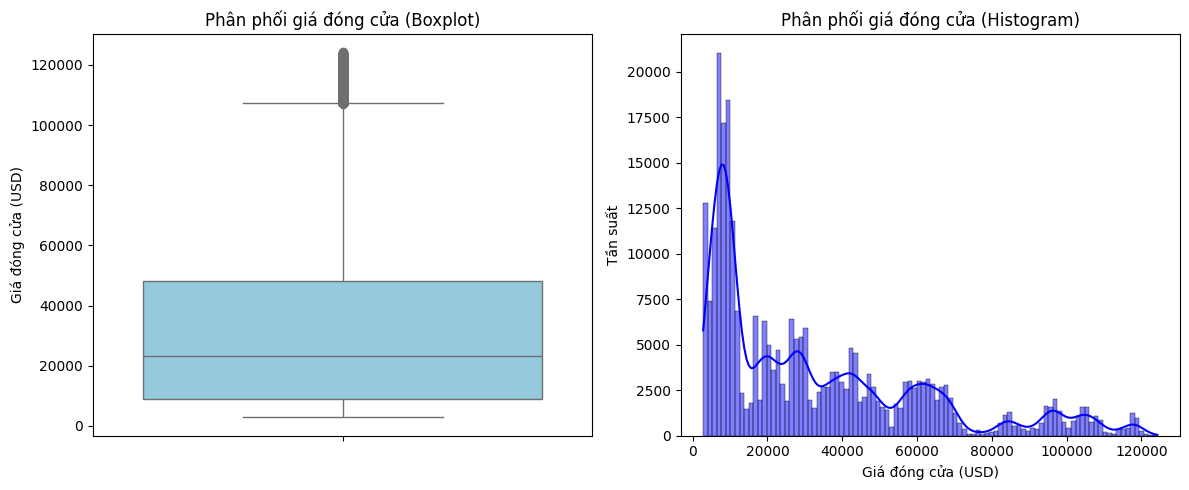

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot
sns.boxplot(y=df['Close'], ax=axes[0], color='skyblue')
axes[0].set_title("Phân phối giá đóng cửa (Boxplot)")
axes[0].set_ylabel("Giá đóng cửa (USD)")

# Histogram
sns.histplot(df['Close'], bins=100, kde=True, color='blue', ax=axes[1])
axes[1].set_title("Phân phối giá đóng cửa (Histogram)")
axes[1].set_xlabel("Giá đóng cửa (USD)")
axes[1].set_ylabel("Tần suất")

plt.tight_layout()
plt.show()


# **Phân tích dữ liệu đưa vào LSTM**

In [ ]:
#Đưa dữ liệu đã xử lý vào
drive.mount('/content/drive')
input_path = "/content/drive/MyDrive/BTCUSDT_15m_processed.csv"
df = pd.read_csv(input_path)

print(df.head())
print(df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
             open_time    Open     High      Low    Close    Volume  Year  \
0  2017-08-17 08:45:00  4360.7  4360.70  4360.69  4360.69  0.031285  2017   
1  2017-08-17 09:00:00  4360.0  4360.00  4360.00  4360.00  0.006296  2017   
2  2017-08-17 09:15:00  4360.0  4360.00  4360.00  4360.00  2.288705  2017   
3  2017-08-17 09:30:00  4360.0  4445.78  4360.00  4436.51  8.410800  2017   
4  2017-08-17 09:45:00  4444.0  4444.00  4444.00  4444.00  0.057822  2017   

        MA20      RSI14  
0  4319.2215  58.335040  
1  4324.1475  65.875549  
2  4329.0750  61.623309  
3  4335.3970  70.964059  
4  4342.1555  77.414035  
(280233, 9)


##**Gán nhãn dữ liệu**

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'RSI14']

In [ ]:
## Target cho hồi quy
y_price = df['Close'].shift(-1)
y_price = y_price.dropna()
X_price  = df[features].loc[y_price.index]

print("Shape hồi quy:", X_price.shape, y_price.shape)
print(y_price.head())

Shape hồi quy: (280232, 7) (280232,)
0    4360.00
1    4360.00
2    4436.51
3    4444.00
4    4400.00
Name: Close, dtype: float64


In [ ]:
# Target cho phân loại
trend = (df['Close'].shift(-1) > df['Close']).astype('float')
y_trend = trend.dropna()
X_trend = df[features].loc[y_trend.index]

print("Shape phân loại:", X_trend.shape, y_trend.shape)
print(y_trend.value_counts())  # Kiểm tra phân bố nhãn
print(y_trend.head())

Shape phân loại: (280233, 7) (280233,)
Close
1.0    141151
0.0    139082
Name: count, dtype: int64
0    0.0
1    0.0
2    1.0
3    1.0
4    0.0
Name: Close, dtype: float64


##**Kiểm tra đặc trưng**

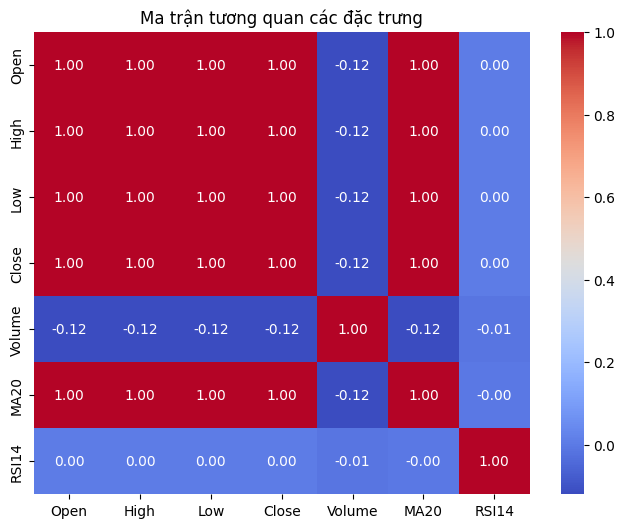

=== Ma trận tương quan ===
            Open      High       Low     Close    Volume      MA20     RSI14
Open    1.000000  0.999993  0.999992  0.999990 -0.119198  0.999949  0.002405
High    0.999993  1.000000  0.999986  0.999994 -0.118364  0.999946  0.002814
Low     0.999992  0.999986  1.000000  0.999993 -0.120186  0.999938  0.003132
Close   0.999990  0.999994  0.999993  1.000000 -0.119252  0.999941  0.003321
Volume -0.119198 -0.118364 -0.120186 -0.119252  1.000000 -0.118909 -0.011666
MA20    0.999949  0.999946  0.999938  0.999941 -0.118909  1.000000 -0.003781
RSI14   0.002405  0.002814  0.003132  0.003321 -0.011666 -0.003781  1.000000


In [ ]:
#Phân tích tương quan
corr = df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan các đặc trưng")
plt.show()

print("=== Ma trận tương quan ===")
print(corr)

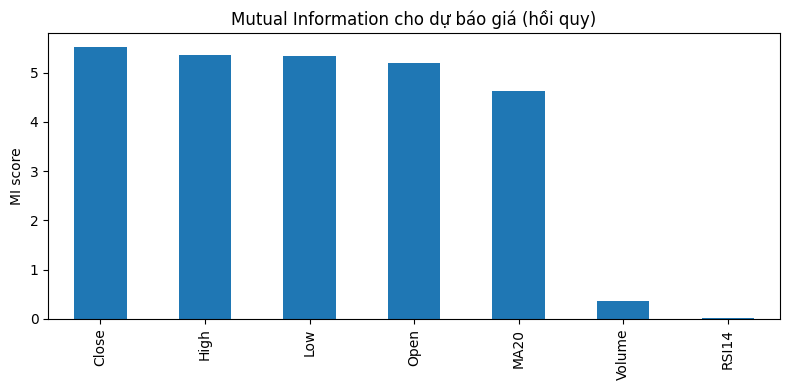

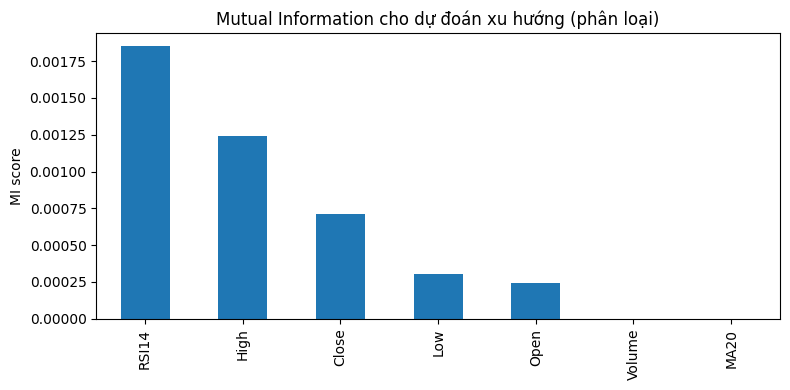


=== Shapes ===
X_price: (280232, 7)  y_price: (280232,)
X_trend: (280233, 7)  y_trend: (280233,)

=== MI cho dự báo giá (Close[t+1]) ===
Close     5.525034
High      5.358657
Low       5.333321
Open      5.189992
MA20      4.634589
Volume    0.360612
RSI14     0.019733
dtype: float64

=== MI cho dự đoán xu hướng (Trend) ===
RSI14     0.001850
High      0.001239
Close     0.000709
Low       0.000306
Open      0.000243
Volume    0.000000
MA20      0.000000
dtype: float64


In [ ]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
# Mutual Information (MI)

# MI cho hồi quy
mi_price = mutual_info_regression(X_price.values, y_price.values, random_state=42)
mi_price_series = pd.Series(mi_price, index=features).sort_values(ascending=False)

# MI cho phân loại
y_trend = y_trend.astype(int)# chuyển lại int 0/1
mi_trend = mutual_info_classif(X_trend.values, y_trend.values, random_state=42)
mi_trend_series = pd.Series(mi_trend, index=features).sort_values(ascending=False)

# Vẽ biểu đồ MI
plt.figure(figsize=(8,4))
mi_price_series.plot(kind='bar')
plt.title("Mutual Information cho dự báo giá (hồi quy)")
plt.ylabel("MI score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
mi_trend_series.plot(kind='bar')
plt.title("Mutual Information cho dự đoán xu hướng (phân loại)")
plt.ylabel("MI score")
plt.tight_layout()
plt.show()

print("\n=== Shapes ===")
print("X_price:", X_price.shape, " y_price:", y_price.shape)
print("X_trend:", X_trend.shape, " y_trend:", y_trend.shape)

print("\n=== MI cho dự báo giá (Close[t+1]) ===")
print(mi_price_series)

print("\n=== MI cho dự đoán xu hướng (Trend) ===")
print(mi_trend_series)